
Anabatic Flow Numerical Simulation
----------------------------------
    Author: Andrew Loeppky
    Course: ATSC 409, Spring 2020
    Professor: Susan Allen, Phil Austin

In [11]:
import context;
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import anabatic_flow_v8 as anfl;

### Case 1: Spin up from quiescent boundary conditions
Starting with zero initial wind velocity and 5 degree surface temperature anomaly, allow the model to reach steady state. We will match the initial/boundary conditions with those provided in (Zardi and Serafin) and specify resolutions to achieve numerical stability.

For the Forward in Time, Centered in Space (FTCS) scheme to remain stable:
$$
\Delta t < \frac{\Delta n^2}{2K}
$$
Note the quadratic dependence of the timestep on the space step, which means doubling the spatial resolution requires increasing the timestep by a factor of 4. This method is very expensive for high resolution simulations.

    dt: 0.04    
    tend: 500.0
    dn: 0.5
    nend: 150.
    
constants:

    g: 9.806
    Km: 3.
    Kh: 3.
    theta_0: 288
    gamma: 0.003
    beta: 30.
 
boundary conditions: 

    theta_surf: 5.
    theta_sky: 0.
    u_surf: 0.
    u_sky: 3.
    initvel: 0.
  

Grid size: (25000, 301)


<Figure size 432x288 with 0 Axes>

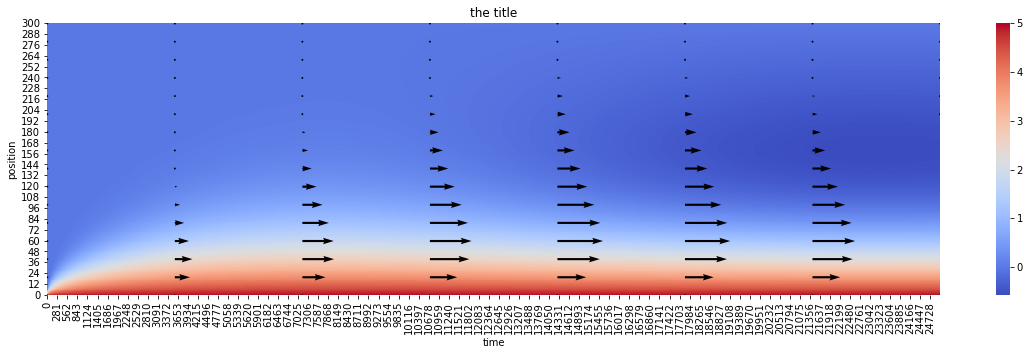

In [2]:
#Steady state, numerical sim
steady_state_num = anfl.Integrator('anabatic_spin_up.yaml','ftcs')
u_ss_num, theta_ss_num = steady_state_num.solve_eqns()
steady_state_num.make_plot(u_ss_num, theta_ss_num)

Now solve the equation analytically for the steady state so we can compare. Use the same initial conditions

Grid size: (25000, 301)


<Figure size 432x288 with 0 Axes>

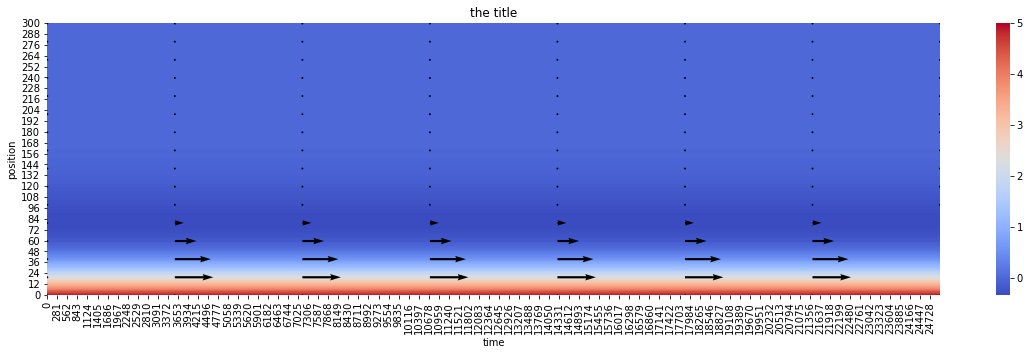

In [19]:
prandtl_exact = anfl.Integrator('anabatic_spin_up.yaml', 'ext_prandtl')
u_prandtl, theta_prandtl = prandtl_exact.solve_eqns()
prandtl_exact.make_plot(u_prandtl, theta_prandtl)

Lets examine the error associated with the numerical simulation. Subtract the exact fields from the simulated ones and plot the error.

Grid size: (25000, 301)


<Figure size 432x288 with 0 Axes>

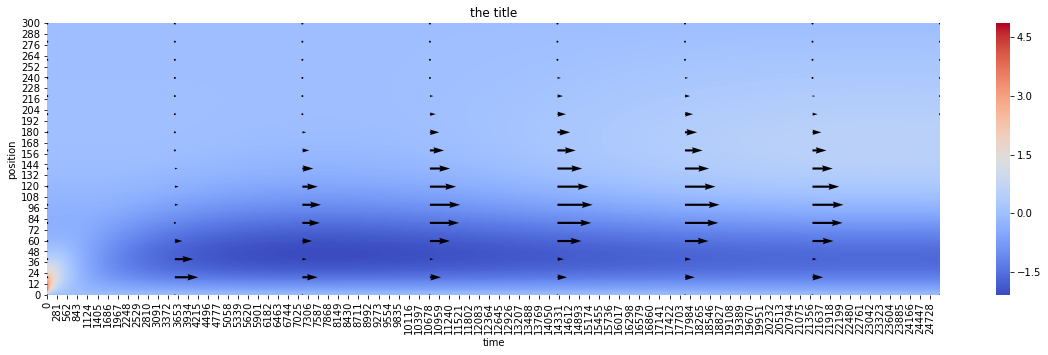

In [8]:
u_err = np.abs(u_prandtl - u_ss_num)
theta_err = theta_prandtl - theta_ss_num

prandtl_exact.make_plot(u_err, theta_err)

## Case 2: Sinusoidal Surface Forcing - 'Diurnal' Cycle
Repeat this analysis for forcing that goes as sin(t/tau) to simulate one anabatic/katabatic cycle. The exact solution to this set was derived by Defant in 1949.

Grid size: (250, 301)


<Figure size 432x288 with 0 Axes>

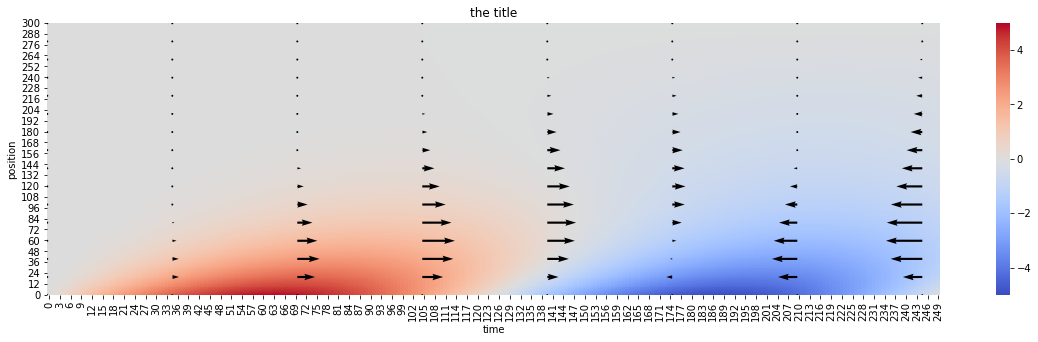

In [13]:
#Numerical sin forcing
sin_force_num = anfl.Integrator('anabatic_1_day.yaml', 'ftcs', forcing = 'diurnal')
u_sf_num, theta_sf_num = sin_force_num.solve_eqns()
sin_force_num.make_plot(u_sf_num[::100], theta_sf_num[::100])

Grid size: (250, 301)


<Figure size 432x288 with 0 Axes>

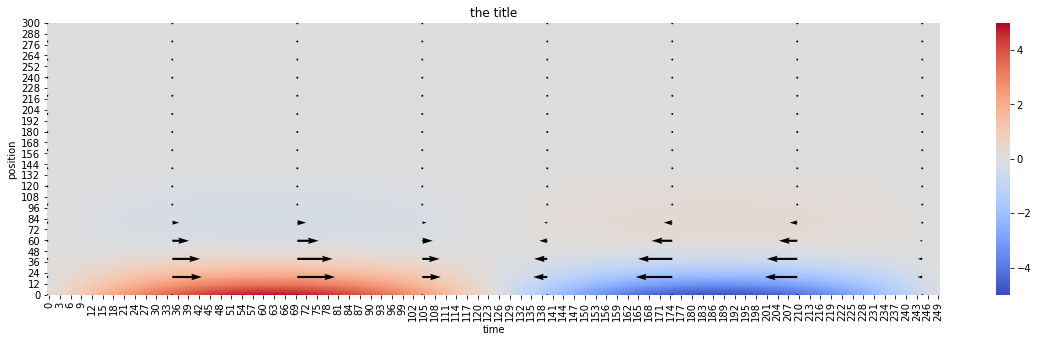

In [14]:
#Analytical sin forcing
defant_exact = anfl.Integrator('anabatic_1_day.yaml', 'ext_defant', forcing = 'diurnal')
u_dfxt, theta_dfxt = defant_exact.solve_eqns()
defant_exact.make_plot(u_dfxt[::100], theta_dfxt[::100])

Grid size: (2500, 301)


<Figure size 432x288 with 0 Axes>

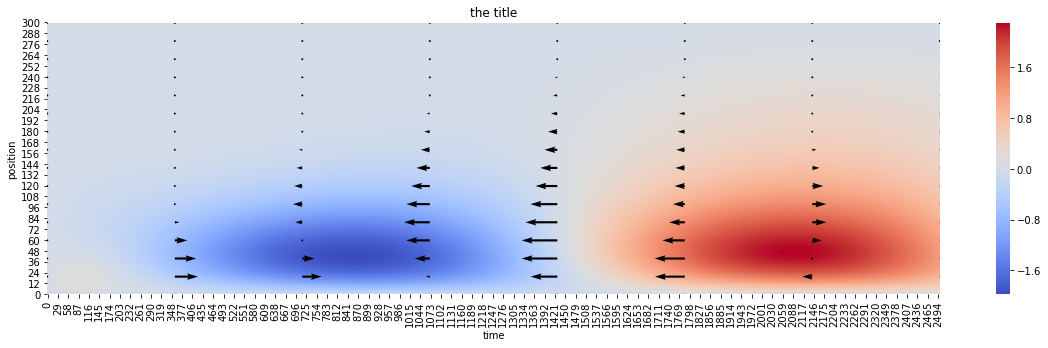

In [7]:
#error = exact - numeric
u_err = u_dfxt - u_sf_num
theta_err = theta_dfxt - theta_sf_num
sin_force_num.make_plot(u_err[::100], theta_err[::100])

## The error is huge...
Error in the FTCS scheme are as high as 40% when compared with the analytical solution. This is obviously a problem that needs to be addressed. Numerical simulations of diffusion-type problems are subject to "numerical diffusion," where the truncation error at each step has the effect of overestimating the diffusion constant (in our case $K_m$ and $K_h$). Low order schemes like FTCS suffer worse than higher order ones. 

#### How can we account for this?
Since the exact solutions are available to this set of equations, they can be used to tune the numerical model. If we define an effective eddy viscosity $K'$:

$$
K' = K * K_{numeric}
$$

$K_{numeric}$ can be estimated from the above plot, and $K'$ chosen to minimize the difference between the exact and numerical solutions. Provided we can accurately estimate $K'$, this effect is actually quite helpful. Recall the stability condition for the FTCS scheme:

$$
\Delta t < \frac{\Delta n^2}{2K}
$$

Since we now get to use a smaller "physical K" value, we can increase our timestep proportionally. Further, the smaller diffusion constant means that $u$ and $\theta$ will not propagate as far away from the slope, so we can lower the ceiling that represents $n \rightarrow \infty$, shrinking the grid!

Grid size: (25000, 301)


<Figure size 432x288 with 0 Axes>

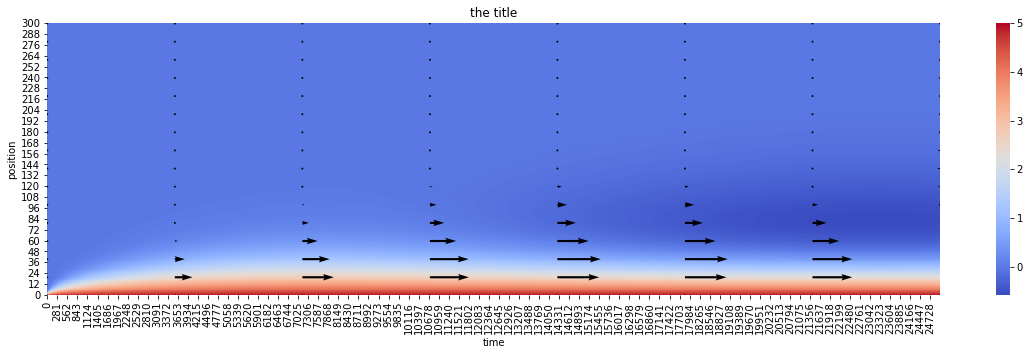

In [23]:
#Steady state simulation with a modified diffusion constant
ss_num_fixed = anfl.Integrator('anabatic_corrected_k.yaml','ftcs')
u_ss_fixed, theta_ss_fixed = ss_num_fixed.solve_eqns()
ss_num_fixed.make_plot(u_ss_fixed, theta_ss_fixed)

Grid size: (25000, 301)


<Figure size 432x288 with 0 Axes>

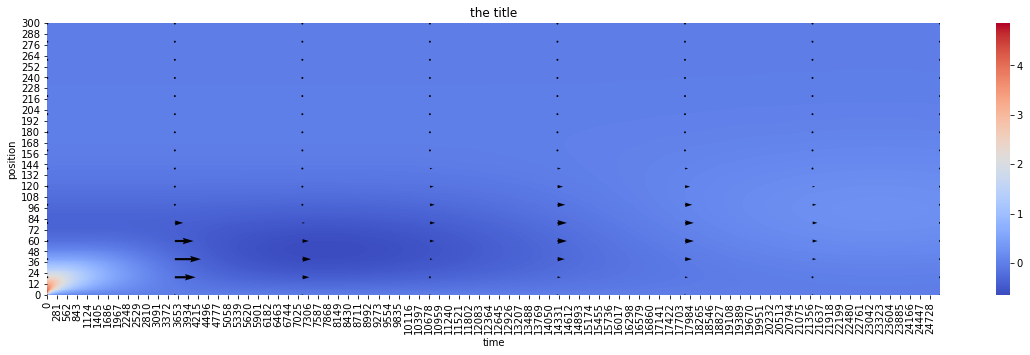

In [24]:
#Again, compare with Prandtl exact solution
u_err = np.abs(u_prandtl - u_ss_fixed)
theta_err = theta_prandtl - theta_ss_fixed

prandtl_exact.make_plot(u_err, theta_err)